# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 32  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] /5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29702.923828125
iteration 0 loss 18298.8671875


iteration 500 loss 191.6780548095703


iteration 1000 loss 170.82150268554688


iteration 1500 loss 146.31529235839844


iteration 2000 loss 99.697998046875


iteration 2500 loss 22.033296585083008


iteration 3000 loss 10.133159637451172


iteration 3500 loss 8.369393348693848


iteration 4000 loss 6.558860778808594


iteration 4500 loss 5.134522438049316


iteration 5000 loss 3.964911699295044


iteration 5500 loss 3.626978874206543


iteration 6000 loss 3.051868200302124


iteration 6500 loss 2.6556284427642822


iteration 7000 loss 2.3173866271972656


iteration 7500 loss 19.145397186279297


iteration 8000 loss 2.0899391174316406


iteration 8500 loss 1.8822178840637207


iteration 9000 loss 1.7253679037094116


iteration 9500 loss 1.583715558052063


iteration 10000 loss 2.5271873474121094


iteration 10500 loss 1.4771510362625122


iteration 11000 loss 1.3653168678283691


iteration 11500 loss 1.2741880416870117


iteration 12000 loss 1.461818814277649


iteration 12500 loss 1.2416962385177612


iteration 13000 loss 1.1607941389083862


iteration 13500 loss 1.096171259880066


iteration 14000 loss 29.558897018432617


iteration 14500 loss 1.0940582752227783


iteration 15000 loss 1.0192419290542603


iteration 15500 loss 0.9672729969024658


iteration 16000 loss 0.9210720658302307


iteration 16500 loss 0.9539931416511536


iteration 17000 loss 0.8975154757499695


iteration 17500 loss 0.8591975569725037


iteration 18000 loss 2.15555739402771


iteration 18500 loss 0.8560587763786316


iteration 19000 loss 0.812163770198822


iteration 19500 loss 0.7811639308929443


iteration 20000 loss 0.9540109038352966


iteration 20500 loss 0.7920038104057312


iteration 21000 loss 0.752273440361023


iteration 21500 loss 0.7247271537780762


iteration 22000 loss 0.8646277189254761


iteration 22500 loss 0.7252200841903687


iteration 23000 loss 0.6931148171424866


iteration 23500 loss 0.6703410148620605


iteration 24000 loss 0.7481681704521179


iteration 24500 loss 0.6778944134712219


iteration 25000 loss 0.6505657434463501


iteration 25500 loss 0.6306946873664856


iteration 26000 loss 0.6391862630844116


iteration 26500 loss 0.6118937134742737


iteration 27000 loss 202.37106323242188


iteration 27500 loss 0.6330620050430298


iteration 28000 loss 0.599828839302063


iteration 28500 loss 0.581112265586853


iteration 29000 loss 31.045320510864258


iteration 29500 loss 0.5713938474655151


iteration 30000 loss 0.5531536936759949


iteration 30500 loss 0.5943692326545715


iteration 31000 loss 0.5525635480880737


iteration 31500 loss 0.5356086492538452


iteration 32000 loss 0.7675216794013977


iteration 32500 loss 0.5333577990531921


iteration 33000 loss 0.516562283039093


iteration 33500 loss 1.2132267951965332


iteration 34000 loss 0.5222330689430237


iteration 34500 loss 0.5031462907791138


iteration 35000 loss 0.49160438776016235


iteration 35500 loss 0.5066168308258057


iteration 36000 loss 0.48686906695365906


iteration 36500 loss 0.4758107364177704


iteration 37000 loss 0.5041494965553284


iteration 37500 loss 0.47775620222091675


iteration 38000 loss 0.4654119908809662


iteration 38500 loss 0.4810918867588043


iteration 39000 loss 0.4582958519458771


iteration 39500 loss 0.4606861174106598


iteration 40000 loss 0.45498085021972656


iteration 40500 loss 0.4424063265323639


iteration 41000 loss 0.4577869474887848


iteration 41500 loss 0.43685251474380493


iteration 42000 loss 44.33799743652344


iteration 42500 loss 0.43175214529037476


iteration 43000 loss 0.423814594745636


iteration 43500 loss 0.44455671310424805


iteration 44000 loss 0.4219604730606079


iteration 44500 loss 0.41264793276786804


iteration 45000 loss 0.41124558448791504


iteration 45500 loss 1.0459532737731934


iteration 46000 loss 0.4064895510673523


iteration 46500 loss 0.3978658616542816


iteration 47000 loss 0.4071371555328369


iteration 47500 loss 0.3950887620449066


iteration 48000 loss 0.40874922275543213


iteration 48500 loss 0.3892648220062256


iteration 49000 loss 0.42244452238082886


iteration 49500 loss 0.3879585862159729


iteration 50000 loss 0.3799152374267578


iteration 50500 loss 0.37787824869155884


iteration 51000 loss 0.3790801763534546


iteration 51500 loss 0.38269880414009094


iteration 52000 loss 0.3705718517303467


iteration 52500 loss 0.3736366629600525


iteration 53000 loss 0.3682633340358734


iteration 53500 loss 0.3649868965148926


iteration 54000 loss 58.12471008300781


iteration 54500 loss 0.35983553528785706


iteration 55000 loss 0.37393513321876526


iteration 55500 loss 0.3532828390598297


iteration 56000 loss 0.36020222306251526


iteration 56500 loss 0.3488560914993286


iteration 57000 loss 0.3673052489757538


iteration 57500 loss 0.3484058380126953


iteration 58000 loss 0.392767071723938


iteration 58500 loss 0.34284496307373047


iteration 59000 loss 0.5946930646896362


iteration 59500 loss 0.34011802077293396


iteration 60000 loss 0.4610583782196045


iteration 60500 loss 0.3349975049495697


iteration 61000 loss 0.3364952504634857


iteration 61500 loss 0.3286857604980469


iteration 62000 loss 0.3294312357902527


iteration 62500 loss 0.32964715361595154


iteration 63000 loss 0.4741736650466919


iteration 63500 loss 0.32267093658447266


iteration 64000 loss 0.3226459324359894


iteration 64500 loss 0.3239307701587677


iteration 65000 loss 0.3416714668273926


iteration 65500 loss 0.3152640461921692


iteration 66000 loss 0.3153492212295532


iteration 66500 loss 0.3174375295639038


iteration 67000 loss 0.31820327043533325


iteration 67500 loss 0.3541595935821533


iteration 68000 loss 0.33784395456314087


iteration 68500 loss 0.3066262900829315


iteration 69000 loss 0.304657518863678


iteration 69500 loss 0.3035855293273926


iteration 70000 loss 0.3023410141468048


iteration 70500 loss 0.3026200532913208


iteration 71000 loss 0.3046896755695343


iteration 71500 loss 0.910034716129303


iteration 72000 loss 0.32133933901786804


iteration 72500 loss 0.3237205743789673


iteration 73000 loss 0.8044842481613159


iteration 73500 loss 19.980058670043945


iteration 74000 loss 0.29160892963409424


iteration 74500 loss 0.2921005189418793


iteration 75000 loss 0.29125598073005676


iteration 75500 loss 0.2898746430873871


iteration 76000 loss 0.288729190826416


iteration 76500 loss 0.2868945896625519


iteration 77000 loss 0.28520798683166504


iteration 77500 loss 0.2838570773601532


iteration 78000 loss 0.2820163071155548


iteration 78500 loss 0.28070199489593506


iteration 79000 loss 0.3226996064186096


iteration 79500 loss 0.3146504759788513


iteration 80000 loss 0.2841992974281311


iteration 80500 loss 0.28104549646377563


iteration 81000 loss 0.2773846387863159


iteration 81500 loss 0.2760654091835022


iteration 82000 loss 0.2751670777797699


iteration 82500 loss 0.27270475029945374


iteration 83000 loss 0.2716366648674011


iteration 83500 loss 0.2697862386703491


iteration 84000 loss 0.4241747558116913


iteration 84500 loss 0.27133020758628845


iteration 85000 loss 0.26804184913635254


iteration 85500 loss 0.26606813073158264


iteration 86000 loss 0.2655301094055176


iteration 86500 loss 0.26626214385032654


iteration 87000 loss 0.26358291506767273


iteration 87500 loss 0.2659246623516083


iteration 88000 loss 0.26286154985427856


iteration 88500 loss 11.37336254119873


iteration 89000 loss 0.2626173496246338


iteration 89500 loss 0.26060351729393005


iteration 90000 loss 0.2581739127635956


iteration 90500 loss 0.3313237130641937


iteration 91000 loss 0.25952786207199097


iteration 91500 loss 0.25676581263542175


iteration 92000 loss 0.25665727257728577


iteration 92500 loss 0.2597092390060425


iteration 93000 loss 0.2668690085411072


iteration 93500 loss 2.29348087310791


iteration 94000 loss 0.5777029395103455


iteration 94500 loss 0.2704746425151825


iteration 95000 loss 0.2503810524940491


iteration 95500 loss 0.25484681129455566


iteration 96000 loss 0.53794264793396


iteration 96500 loss 0.24898554384708405


iteration 97000 loss 0.2479710876941681


iteration 97500 loss 0.24694198369979858


iteration 98000 loss 0.24535995721817017


iteration 98500 loss 0.3232763111591339


iteration 99000 loss 0.24613600969314575


iteration 99500 loss 0.24853387475013733


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.33745360374450684


iteration 100500 loss 0.24472379684448242


iteration 101000 loss 0.24272634088993073


iteration 101500 loss 0.24141830205917358


iteration 102000 loss 0.2404049038887024


iteration 102500 loss 0.23949256539344788


iteration 103000 loss 0.23856566846370697


iteration 103500 loss 0.23754949867725372


iteration 104000 loss 0.23713676631450653


iteration 104500 loss 0.23587772250175476


iteration 105000 loss 0.23503798246383667


iteration 105500 loss 0.24728256464004517


iteration 106000 loss 0.23358026146888733


iteration 106500 loss 0.23284916579723358


iteration 107000 loss 0.2353789210319519


iteration 107500 loss 0.23137794435024261


iteration 108000 loss 0.23063121736049652


iteration 108500 loss 0.22974969446659088


iteration 109000 loss 0.22925814986228943


iteration 109500 loss 0.22858455777168274


iteration 110000 loss 0.22780920565128326


iteration 110500 loss 0.22725239396095276


iteration 111000 loss 0.22691503167152405


iteration 111500 loss 0.22630555927753448


iteration 112000 loss 0.22529453039169312


iteration 112500 loss 0.22460709512233734


iteration 113000 loss 0.22407491505146027


iteration 113500 loss 0.2234213501214981


iteration 114000 loss 0.22274169325828552


iteration 114500 loss 0.22215111553668976


iteration 115000 loss 0.22151219844818115


iteration 115500 loss 0.22092661261558533


iteration 116000 loss 0.22029262781143188


iteration 116500 loss 0.21992255747318268


iteration 117000 loss 0.2191222608089447


iteration 117500 loss 0.21855157613754272


iteration 118000 loss 0.2179526835680008


iteration 118500 loss 0.21746256947517395


iteration 119000 loss 0.21689781546592712


iteration 119500 loss 0.21620070934295654


iteration 120000 loss 0.8708433508872986


iteration 120500 loss 0.21505729854106903


iteration 121000 loss 0.2169763594865799


iteration 121500 loss 0.21399660408496857


iteration 122000 loss 0.2133975476026535


iteration 122500 loss 0.21353811025619507


iteration 123000 loss 0.21229533851146698


iteration 123500 loss 0.2118949592113495


iteration 124000 loss 0.21116945147514343


iteration 124500 loss 0.21073803305625916


iteration 125000 loss 0.21002916991710663


iteration 125500 loss 0.5725103616714478


iteration 126000 loss 0.2089226245880127


iteration 126500 loss 0.21062494814395905


iteration 127000 loss 0.20787860453128815


iteration 127500 loss 0.2073373943567276


iteration 128000 loss 0.20696872472763062


iteration 128500 loss 0.2063259482383728


iteration 129000 loss 0.2065252810716629


iteration 129500 loss 0.2053220123052597


iteration 130000 loss 0.20486393570899963


iteration 130500 loss 0.2044728398323059


iteration 131000 loss 0.2038610279560089


iteration 131500 loss 0.20338983833789825


iteration 132000 loss 0.20307493209838867


iteration 132500 loss 0.20244917273521423


iteration 133000 loss 0.20192337036132812


iteration 133500 loss 0.20150452852249146


iteration 134000 loss 0.20192760229110718


iteration 134500 loss 0.20068377256393433


iteration 135000 loss 0.2000887393951416


iteration 135500 loss 0.2013142704963684


iteration 136000 loss 0.1991976797580719


iteration 136500 loss 0.19874203205108643


iteration 137000 loss 0.19936703145503998


iteration 137500 loss 0.19783081114292145


iteration 138000 loss 0.8121885657310486


iteration 138500 loss 0.19693149626255035


iteration 139000 loss 0.21516257524490356


iteration 139500 loss 0.19603417813777924


iteration 140000 loss 0.1958475559949875


iteration 140500 loss 0.19513382017612457


iteration 141000 loss 0.19708232581615448


iteration 141500 loss 0.1943034827709198


iteration 142000 loss 0.19384676218032837


iteration 142500 loss 0.19353944063186646


iteration 143000 loss 0.19304755330085754


iteration 143500 loss 0.19339165091514587


iteration 144000 loss 0.19223955273628235


iteration 144500 loss 0.1923055648803711


iteration 145000 loss 0.19145949184894562


iteration 145500 loss 0.1909862607717514


iteration 146000 loss 0.19066710770130157


iteration 146500 loss 0.19018082320690155


iteration 147000 loss 0.19286422431468964


iteration 147500 loss 0.18938808143138885


iteration 148000 loss 0.1970754861831665


iteration 148500 loss 0.1885957270860672


iteration 149000 loss 0.1882692575454712


iteration 149500 loss 0.18781979382038116


iteration 150000 loss 0.18739427626132965


iteration 150500 loss 0.1870591789484024


iteration 151000 loss 0.18679115176200867


iteration 151500 loss 0.18629640340805054


iteration 152000 loss 0.18588972091674805


iteration 152500 loss 0.18550549447536469


iteration 153000 loss 0.18514128029346466


iteration 153500 loss 0.1847672015428543


iteration 154000 loss 0.184398353099823


iteration 154500 loss 0.1841055154800415


iteration 155000 loss 0.1836480349302292


iteration 155500 loss 0.18358132243156433


iteration 156000 loss 0.1828882247209549


iteration 156500 loss 0.18267987668514252


iteration 157000 loss 0.18218956887722015


iteration 157500 loss 0.1817961037158966


iteration 158000 loss 0.18149589002132416


iteration 158500 loss 0.18111348152160645


iteration 159000 loss 0.18082617223262787


iteration 159500 loss 0.1804189234972


iteration 160000 loss 0.18040065467357635


iteration 160500 loss 0.1797841191291809


iteration 161000 loss 0.17941582202911377


iteration 161500 loss 0.17912860214710236


iteration 162000 loss 0.17874334752559662


iteration 162500 loss 0.1785988062620163


iteration 163000 loss 0.17809154093265533


iteration 163500 loss 0.3290751278400421


iteration 164000 loss 0.17740459740161896


iteration 164500 loss 0.17772161960601807


iteration 165000 loss 0.17675642669200897


iteration 165500 loss 0.17650897800922394


iteration 166000 loss 0.1760898381471634


iteration 166500 loss 0.1758592426776886


iteration 167000 loss 0.17584294080734253


iteration 167500 loss 0.17510917782783508


iteration 168000 loss 0.18132047355175018


iteration 168500 loss 0.17450173199176788


iteration 169000 loss 0.17412979900836945


iteration 169500 loss 0.1738821566104889


iteration 170000 loss 0.175502210855484


iteration 170500 loss 0.17325802147388458


iteration 171000 loss 0.17287057638168335


iteration 171500 loss 0.20296938717365265


iteration 172000 loss 0.1722756177186966


iteration 172500 loss 0.17369209229946136


iteration 173000 loss 0.1717037856578827


iteration 173500 loss 0.17136161029338837


iteration 174000 loss 0.17111726105213165


iteration 174500 loss 0.17150431871414185


iteration 175000 loss 0.17049382627010345


iteration 175500 loss 0.17052197456359863


iteration 176000 loss 0.1698998510837555


iteration 176500 loss 0.16956296563148499


iteration 177000 loss 0.16929712891578674


iteration 177500 loss 0.17206652462482452


iteration 178000 loss 0.1686955839395523


iteration 178500 loss 0.1685105413198471


iteration 179000 loss 0.16811221837997437


iteration 179500 loss 1.539521336555481


iteration 180000 loss 0.1675289273262024


iteration 180500 loss 0.16732226312160492


iteration 181000 loss 0.16738727688789368


iteration 181500 loss 0.1666606217622757


iteration 182000 loss 0.16716882586479187


iteration 182500 loss 0.16610239446163177


iteration 183000 loss 0.1663694977760315


iteration 183500 loss 0.1655357927083969


iteration 184000 loss 0.16542182862758636


iteration 184500 loss 0.16499073803424835


iteration 185000 loss 0.16533532738685608


iteration 185500 loss 0.1644381582736969


iteration 186000 loss 0.16456164419651031


iteration 186500 loss 0.163914754986763


iteration 187000 loss 0.17528143525123596


iteration 187500 loss 0.16336780786514282


iteration 188000 loss 0.4884939193725586


iteration 188500 loss 0.16284646093845367


iteration 189000 loss 0.16255012154579163


iteration 189500 loss 0.16230666637420654


iteration 190000 loss 0.3065021336078644


iteration 190500 loss 0.1618015021085739


iteration 191000 loss 0.16151583194732666


iteration 191500 loss 0.16127987205982208


iteration 192000 loss 0.1609840840101242


iteration 192500 loss 0.1607593446969986


iteration 193000 loss 0.16478244960308075


iteration 193500 loss 0.16023634374141693


iteration 194000 loss 0.16003483533859253


iteration 194500 loss 0.1599251925945282


iteration 195000 loss 0.15952417254447937


iteration 195500 loss 0.15956513583660126


iteration 196000 loss 0.15898676216602325


iteration 196500 loss 0.1586906760931015


iteration 197000 loss 0.1584852933883667


iteration 197500 loss 0.15842783451080322


iteration 198000 loss 0.15801915526390076


iteration 198500 loss 0.1577477753162384


iteration 199000 loss 0.1575523465871811


iteration 199500 loss 0.15726600587368011


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.1570306420326233


iteration 200500 loss 0.1569676548242569


iteration 201000 loss 0.15689410269260406


iteration 201500 loss 0.15680353343486786


iteration 202000 loss 0.15668967366218567


iteration 202500 loss 0.15654465556144714


iteration 203000 loss 0.15635965764522552


iteration 203500 loss 0.15612289309501648


iteration 204000 loss 0.15588398277759552


iteration 204500 loss 0.15559178590774536


iteration 205000 loss 0.155411034822464


iteration 205500 loss 0.15519361197948456


iteration 206000 loss 0.1549101620912552


iteration 206500 loss 0.1546296626329422


iteration 207000 loss 0.15446797013282776


iteration 207500 loss 0.15427277982234955


iteration 208000 loss 0.15410146117210388


iteration 208500 loss 0.15373149514198303


iteration 209000 loss 0.15355288982391357


iteration 209500 loss 0.15337829291820526


iteration 210000 loss 0.1531621515750885


iteration 210500 loss 0.15297605097293854


iteration 211000 loss 0.1526588350534439


iteration 211500 loss 0.15248440206050873


iteration 212000 loss 0.15226787328720093


iteration 212500 loss 0.1520088165998459


iteration 213000 loss 0.1517711728811264


iteration 213500 loss 0.15160077810287476


iteration 214000 loss 0.1514013111591339


iteration 214500 loss 0.15112416446208954


iteration 215000 loss 0.15088458359241486


iteration 215500 loss 0.15071217715740204


iteration 216000 loss 0.1505730152130127


iteration 216500 loss 0.1502292901277542


iteration 217000 loss 0.14999230206012726


iteration 217500 loss 0.14983698725700378


iteration 218000 loss 0.14968839287757874


iteration 218500 loss 0.1495213359594345


iteration 219000 loss 0.14946360886096954


iteration 219500 loss 0.1583307534456253


iteration 220000 loss 0.1488400101661682


iteration 220500 loss 0.14866751432418823


iteration 221000 loss 0.14844752848148346


iteration 221500 loss 0.1481814682483673


iteration 222000 loss 0.14801384508609772


iteration 222500 loss 0.1478489339351654


iteration 223000 loss 0.14764286577701569


iteration 223500 loss 0.1474861353635788


iteration 224000 loss 0.14716927707195282


iteration 224500 loss 0.14700131118297577


iteration 225000 loss 0.14679577946662903


iteration 225500 loss 0.14673104882240295


iteration 226000 loss 0.14634571969509125


iteration 226500 loss 0.14617550373077393


iteration 227000 loss 0.14597631990909576


iteration 227500 loss 0.14578400552272797


iteration 228000 loss 0.14552609622478485


iteration 228500 loss 0.1453748196363449


iteration 229000 loss 0.14518605172634125


iteration 229500 loss 0.14497853815555573


iteration 230000 loss 0.14473387598991394


iteration 230500 loss 0.14460228383541107


iteration 231000 loss 0.14444394409656525


iteration 231500 loss 0.14424540102481842


iteration 232000 loss 0.14436909556388855


iteration 232500 loss 0.14384891092777252


iteration 233000 loss 0.14365966618061066


iteration 233500 loss 0.1437085121870041


iteration 234000 loss 0.1432473510503769


iteration 234500 loss 0.1431165486574173


iteration 235000 loss 0.14299646019935608


iteration 235500 loss 0.14275531470775604


iteration 236000 loss 0.14289897680282593


iteration 236500 loss 0.14238645136356354


iteration 237000 loss 0.14223256707191467


iteration 237500 loss 0.1422460973262787


iteration 238000 loss 0.14183951914310455


iteration 238500 loss 0.141672283411026


iteration 239000 loss 0.1414918601512909


iteration 239500 loss 0.1413935422897339


iteration 240000 loss 0.14109396934509277


iteration 240500 loss 0.14094685018062592


iteration 241000 loss 0.1408804953098297


iteration 241500 loss 0.14082551002502441


iteration 242000 loss 0.1403704285621643


iteration 242500 loss 0.14023981988430023


iteration 243000 loss 0.1400822103023529


iteration 243500 loss 0.13993073999881744


iteration 244000 loss 0.13968592882156372


iteration 244500 loss 0.13952094316482544


iteration 245000 loss 0.13936147093772888


iteration 245500 loss 0.13918562233448029


iteration 246000 loss 0.13896477222442627


iteration 246500 loss 0.1388181447982788


iteration 247000 loss 0.1386527121067047


iteration 247500 loss 0.13848081231117249


iteration 248000 loss 0.13826310634613037


iteration 248500 loss 0.13813358545303345


iteration 249000 loss 0.13798531889915466


iteration 249500 loss 0.13780540227890015


iteration 250000 loss 0.13767839968204498


iteration 250500 loss 0.13746514916419983


iteration 251000 loss 0.1373264491558075


iteration 251500 loss 0.13715295493602753


iteration 252000 loss 0.1370038390159607


iteration 252500 loss 0.13679228723049164


iteration 253000 loss 0.1366652250289917


iteration 253500 loss 0.13651351630687714


iteration 254000 loss 0.1363232582807541


iteration 254500 loss 0.13612139225006104


iteration 255000 loss 0.13598084449768066


iteration 255500 loss 0.1358330100774765


iteration 256000 loss 0.13574153184890747


iteration 256500 loss 0.1354837864637375


iteration 257000 loss 0.13532055914402008


iteration 257500 loss 0.13516946136951447


iteration 258000 loss 0.13500109314918518


iteration 258500 loss 0.13490036129951477


iteration 259000 loss 0.13465288281440735


iteration 259500 loss 0.13451595604419708


iteration 260000 loss 0.1343824714422226


iteration 260500 loss 0.13422025740146637


iteration 261000 loss 0.13402429223060608


iteration 261500 loss 0.13389962911605835


iteration 262000 loss 0.13384652137756348


iteration 262500 loss 0.13380885124206543


iteration 263000 loss 0.13340090215206146


iteration 263500 loss 0.13327868282794952


iteration 264000 loss 0.13315165042877197


iteration 264500 loss 0.161871999502182


iteration 265000 loss 0.1327999234199524


iteration 265500 loss 0.13265559077262878


iteration 266000 loss 0.13303473591804504


iteration 266500 loss 0.13231143355369568


iteration 267000 loss 0.13217231631278992


iteration 267500 loss 0.13199996948242188


iteration 268000 loss 0.13183893263339996


iteration 268500 loss 0.13170577585697174


iteration 269000 loss 0.13157211244106293


iteration 269500 loss 0.1315321922302246


iteration 270000 loss 0.14237819612026215


iteration 270500 loss 0.13109426200389862


iteration 271000 loss 0.13095836341381073


iteration 271500 loss 0.13088427484035492


iteration 272000 loss 0.13061974942684174


iteration 272500 loss 0.1305050551891327


iteration 273000 loss 0.1303788274526596


iteration 273500 loss 0.13032422959804535


iteration 274000 loss 0.13005414605140686


iteration 274500 loss 0.12991684675216675


iteration 275000 loss 0.1300216168165207


iteration 275500 loss 0.12959089875221252


iteration 276000 loss 0.1294841319322586


iteration 276500 loss 0.1293620765209198


iteration 277000 loss 0.12923258543014526


iteration 277500 loss 0.12905196845531464


iteration 278000 loss 0.12890417873859406


iteration 278500 loss 0.1287979930639267


iteration 279000 loss 0.1286829262971878


iteration 279500 loss 0.12854008376598358


iteration 280000 loss 0.12833839654922485


iteration 280500 loss 0.12821964919567108


iteration 281000 loss 0.12808485329151154


iteration 281500 loss 0.12811489403247833


iteration 282000 loss 0.1277630776166916


iteration 282500 loss 0.12765121459960938


iteration 283000 loss 0.1275653839111328


iteration 283500 loss 0.12743082642555237


iteration 284000 loss 0.12720540165901184


iteration 284500 loss 0.12710261344909668


iteration 285000 loss 0.1269853413105011


iteration 285500 loss 0.1270385980606079


iteration 286000 loss 0.1268950253725052


iteration 286500 loss 0.1265404224395752


iteration 287000 loss 0.12642116844654083


iteration 287500 loss 0.12639349699020386


iteration 288000 loss 0.12612482905387878


iteration 288500 loss 0.12601009011268616


iteration 289000 loss 0.12588509917259216


iteration 289500 loss 0.12573498487472534


iteration 290000 loss 0.12558646500110626


iteration 290500 loss 0.12547719478607178


iteration 291000 loss 0.12535953521728516


iteration 291500 loss 0.1252298504114151


iteration 292000 loss 0.14868436753749847


iteration 292500 loss 0.12493349611759186


iteration 293000 loss 0.12481169402599335


iteration 293500 loss 0.12465829402208328


iteration 294000 loss 0.12451615929603577


iteration 294500 loss 0.12440355867147446


iteration 295000 loss 0.12445967644453049


iteration 295500 loss 0.12415624409914017


iteration 296000 loss 0.12398158758878708


iteration 296500 loss 0.12388022243976593


iteration 297000 loss 0.12377511709928513


iteration 297500 loss 0.12365817278623581


iteration 298000 loss 0.12351582944393158


iteration 298500 loss 0.12337404489517212


iteration 299000 loss 0.12326159328222275


iteration 299500 loss 0.12322094291448593


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.12297753244638443


iteration 300500 loss 0.12294819951057434


iteration 301000 loss 0.12291928380727768


iteration 301500 loss 0.12288422882556915


iteration 302000 loss 0.12283969670534134


iteration 302500 loss 0.12278281897306442


iteration 303000 loss 0.12271000444889069


iteration 303500 loss 0.12261665612459183


iteration 304000 loss 0.12249740958213806


iteration 304500 loss 0.12234891951084137


iteration 305000 loss 0.1221635714173317


iteration 305500 loss 0.1220523864030838


iteration 306000 loss 0.12195832282304764


iteration 306500 loss 0.12184523791074753


iteration 307000 loss 0.12169146537780762


iteration 307500 loss 0.12150067836046219


iteration 308000 loss 0.12141049653291702


iteration 308500 loss 0.1213139146566391


iteration 309000 loss 0.12119157612323761


iteration 309500 loss 0.12104108929634094


iteration 310000 loss 0.12094592303037643


iteration 310500 loss 0.12078572809696198


iteration 311000 loss 0.12069651484489441


iteration 311500 loss 0.12058332562446594


iteration 312000 loss 0.12044709175825119


iteration 312500 loss 0.12026693671941757


iteration 313000 loss 0.12016262859106064


iteration 313500 loss 0.12008420377969742


iteration 314000 loss 0.11998435109853745


iteration 314500 loss 0.11985809355974197


iteration 315000 loss 0.11969979107379913


iteration 315500 loss 0.1195485070347786


iteration 316000 loss 0.11946482956409454


iteration 316500 loss 0.11935795843601227


iteration 317000 loss 0.11922691017389297


iteration 317500 loss 0.11905563622713089


iteration 318000 loss 0.11894436925649643


iteration 318500 loss 0.11886763572692871


iteration 319000 loss 0.11876969784498215


iteration 319500 loss 0.11864682286977768


iteration 320000 loss 0.1184920147061348


iteration 320500 loss 0.11835675686597824


iteration 321000 loss 0.11827968806028366


iteration 321500 loss 0.1181814894080162


iteration 322000 loss 0.11805939674377441


iteration 322500 loss 0.11790353804826736


iteration 323000 loss 0.1177680641412735


iteration 323500 loss 0.11768098175525665


iteration 324000 loss 0.11757021397352219


iteration 324500 loss 0.11743422597646713


iteration 325000 loss 0.11728160083293915


iteration 325500 loss 0.11720729619264603


iteration 326000 loss 0.11711245030164719


iteration 326500 loss 0.11699565500020981


iteration 327000 loss 0.11685104668140411


iteration 327500 loss 0.1167265996336937


iteration 328000 loss 0.11665210872888565


iteration 328500 loss 0.11655700206756592


iteration 329000 loss 0.11644068360328674


iteration 329500 loss 0.11628993600606918


iteration 330000 loss 0.11616440117359161


iteration 330500 loss 0.1160803958773613


iteration 331000 loss 0.11597682535648346


iteration 331500 loss 0.11583925783634186


iteration 332000 loss 0.1157289519906044


iteration 332500 loss 0.11560565233230591


iteration 333000 loss 0.1155170276761055


iteration 333500 loss 0.11540461331605911


iteration 334000 loss 0.11526978760957718


iteration 334500 loss 0.11512703448534012


iteration 335000 loss 0.11506542563438416


iteration 335500 loss 0.11498693376779556


iteration 336000 loss 0.11488832533359528


iteration 336500 loss 0.11476149410009384


iteration 337000 loss 0.11740132421255112


iteration 337500 loss 0.11454262584447861


iteration 338000 loss 0.11446505784988403


iteration 338500 loss 0.11436782032251358


iteration 339000 loss 0.11425372958183289


iteration 339500 loss 0.1140880212187767


iteration 340000 loss 0.1140003502368927


iteration 340500 loss 0.11391718685626984


iteration 341000 loss 0.11381527781486511


iteration 341500 loss 0.1136796623468399


iteration 342000 loss 0.11353854835033417


iteration 342500 loss 0.11347562819719315


iteration 343000 loss 0.11339535564184189


iteration 343500 loss 0.11329367756843567


iteration 344000 loss 0.11316774785518646


iteration 344500 loss 0.11303261667490005


iteration 345000 loss 0.11296846717596054


iteration 345500 loss 0.11288681626319885


iteration 346000 loss 0.11278743296861649


iteration 346500 loss 0.11265197396278381


iteration 347000 loss 0.11251818388700485


iteration 347500 loss 0.11245028674602509


iteration 348000 loss 0.11236366629600525


iteration 348500 loss 0.11225440353155136


iteration 349000 loss 0.11211617290973663


iteration 349500 loss 0.11200673878192902


iteration 350000 loss 0.11193427443504333


iteration 350500 loss 0.11184587329626083


iteration 351000 loss 0.11173243075609207


iteration 351500 loss 0.11158488690853119


iteration 352000 loss 0.11151060461997986


iteration 352500 loss 0.11144687235355377


iteration 353000 loss 0.11136568337678909


iteration 353500 loss 0.11126293987035751


iteration 354000 loss 0.11112996190786362


iteration 354500 loss 0.11101970821619034


iteration 355000 loss 0.11095131188631058


iteration 355500 loss 0.11086520552635193


iteration 356000 loss 0.11075971275568008


iteration 356500 loss 0.11061874777078629


iteration 357000 loss 0.1105453372001648


iteration 357500 loss 0.11047740280628204


iteration 358000 loss 0.11039140075445175


iteration 358500 loss 0.11028141528367996


iteration 359000 loss 0.11014889925718307


iteration 359500 loss 0.11005497723817825


iteration 360000 loss 0.10998239368200302


iteration 360500 loss 0.10989129543304443


iteration 361000 loss 0.10977473855018616


iteration 361500 loss 0.11227443814277649


iteration 362000 loss 0.10957873612642288


iteration 362500 loss 0.1095164492726326


iteration 363000 loss 0.10943770408630371


iteration 363500 loss 0.10934343189001083


iteration 364000 loss 0.10921528190374374


iteration 364500 loss 0.10910696536302567


iteration 365000 loss 0.1090439185500145


iteration 365500 loss 0.10896391421556473


iteration 366000 loss 0.10886194556951523


iteration 366500 loss 0.10873571783304214


iteration 367000 loss 0.108631931245327


iteration 367500 loss 0.10856850445270538


iteration 368000 loss 0.10849073529243469


iteration 368500 loss 0.10838858038187027


iteration 369000 loss 0.10826171934604645


iteration 369500 loss 0.10817093402147293


iteration 370000 loss 0.10809756815433502


iteration 370500 loss 0.10800854116678238


iteration 371000 loss 0.10788693279027939


iteration 371500 loss 0.10777699947357178


iteration 372000 loss 0.1077236756682396


iteration 372500 loss 0.10765529423952103


iteration 373000 loss 0.10757327824831009


iteration 373500 loss 0.10746413469314575


iteration 374000 loss 0.11047602444887161


iteration 374500 loss 0.10727357119321823


iteration 375000 loss 0.10721414536237717


iteration 375500 loss 0.10714350640773773


iteration 376000 loss 0.1070471927523613


iteration 376500 loss 0.10692474991083145


iteration 377000 loss 0.10683391988277435


iteration 377500 loss 0.10677841305732727


iteration 378000 loss 0.10670734941959381


iteration 378500 loss 0.10661950707435608


iteration 379000 loss 0.10650654137134552


iteration 379500 loss 0.10639845579862595


iteration 380000 loss 0.10634252429008484


iteration 380500 loss 0.10627108067274094


iteration 381000 loss 0.10618473589420319


iteration 381500 loss 0.10606752336025238


iteration 382000 loss 0.10596125572919846


iteration 382500 loss 0.10590315610170364


iteration 383000 loss 0.10582917183637619


iteration 383500 loss 0.10574013739824295


iteration 384000 loss 0.10562413930892944


iteration 384500 loss 0.10552175343036652


iteration 385000 loss 0.10546967387199402


iteration 385500 loss 0.105404332280159


iteration 386000 loss 0.10532739013433456


iteration 386500 loss 0.10521373897790909


iteration 387000 loss 0.10509663075208664


iteration 387500 loss 0.10504350066184998


iteration 388000 loss 0.10497597604990005


iteration 388500 loss 0.10489179193973541


iteration 389000 loss 0.1047811284661293


iteration 389500 loss 0.10467787832021713


iteration 390000 loss 0.10462377965450287


iteration 390500 loss 0.10455521941184998


iteration 391000 loss 0.10446716099977493


iteration 391500 loss 0.10435536503791809


iteration 392000 loss 0.10426506400108337


iteration 392500 loss 0.10421479493379593


iteration 393000 loss 0.10415063053369522


iteration 393500 loss 0.10407382249832153


iteration 394000 loss 0.10397270321846008


iteration 394500 loss 0.10385351628065109


iteration 395000 loss 0.10379669815301895


iteration 395500 loss 0.10372581332921982


iteration 396000 loss 0.10363748669624329


iteration 396500 loss 0.10351916402578354


iteration 397000 loss 0.10343853384256363


iteration 397500 loss 0.10338114947080612


iteration 398000 loss 0.10330839455127716


iteration 398500 loss 0.10321750491857529


iteration 399000 loss 0.10309955477714539


iteration 399500 loss 0.10303710401058197


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 0.10298588871955872


iteration 400500 loss 0.1029728353023529


iteration 401000 loss 0.10295602679252625


iteration 401500 loss 0.10293444246053696


iteration 402000 loss 0.10290686786174774


iteration 402500 loss 0.10287152975797653


iteration 403000 loss 0.10282617062330246


iteration 403500 loss 0.10276824980974197


iteration 404000 loss 0.10269450396299362


iteration 404500 loss 0.10260219126939774


iteration 405000 loss 0.10248605906963348


iteration 405500 loss 0.10238713026046753


iteration 406000 loss 0.10228624939918518


iteration 406500 loss 0.10216841846704483


iteration 407000 loss 0.1020861268043518


iteration 407500 loss 0.1019827350974083


iteration 408000 loss 0.10186295211315155


iteration 408500 loss 0.10175243765115738


iteration 409000 loss 0.10166726261377335


iteration 409500 loss 0.10156021267175674


iteration 410000 loss 0.10145559906959534


iteration 410500 loss 0.10136229544878006


iteration 411000 loss 0.10124606639146805


iteration 411500 loss 0.10116090625524521


iteration 412000 loss 0.1010613963007927


iteration 412500 loss 0.10094887763261795


iteration 413000 loss 0.10085543245077133


iteration 413500 loss 0.10073873400688171


iteration 414000 loss 0.1006554663181305


iteration 414500 loss 0.10055480152368546


iteration 415000 loss 0.10044736415147781


iteration 415500 loss 0.10035409033298492


iteration 416000 loss 0.10030065476894379


iteration 416500 loss 0.1001586988568306


iteration 417000 loss 0.10005906969308853


iteration 417500 loss 0.0999530553817749


iteration 418000 loss 0.09986793994903564


iteration 418500 loss 0.09976144880056381


iteration 419000 loss 0.09967435151338577


iteration 419500 loss 0.09959480166435242


iteration 420000 loss 0.09949477016925812


iteration 420500 loss 0.09939445555210114


iteration 421000 loss 0.09930627048015594


iteration 421500 loss 0.09919583797454834


iteration 422000 loss 0.09911303222179413


iteration 422500 loss 0.09901674091815948


iteration 423000 loss 0.09891293197870255


iteration 423500 loss 0.09883401542901993


iteration 424000 loss 0.09873486310243607


iteration 424500 loss 0.09863164275884628


iteration 425000 loss 0.09852593392133713


iteration 425500 loss 0.09844013303518295


iteration 426000 loss 0.098348468542099


iteration 426500 loss 0.09823700040578842


iteration 427000 loss 0.09816272556781769


iteration 427500 loss 0.0980694517493248


iteration 428000 loss 0.0979643315076828


iteration 428500 loss 0.09789171814918518


iteration 429000 loss 0.0978006049990654


iteration 429500 loss 0.09769618511199951


iteration 430000 loss 0.09762682765722275


iteration 430500 loss 0.09753948450088501


iteration 431000 loss 0.09743084758520126


iteration 431500 loss 0.09735560417175293


iteration 432000 loss 0.09726575016975403


iteration 432500 loss 0.09716290980577469


iteration 433000 loss 0.09709285199642181


iteration 433500 loss 0.09700462222099304


iteration 434000 loss 0.096900574862957


iteration 434500 loss 0.0968264564871788


iteration 435000 loss 0.09673359990119934


iteration 435500 loss 0.0966397225856781


iteration 436000 loss 0.09657103568315506


iteration 436500 loss 0.09648450464010239


iteration 437000 loss 0.09637747704982758


iteration 437500 loss 0.09631182253360748


iteration 438000 loss 0.09623625874519348


iteration 438500 loss 0.09614129364490509


iteration 439000 loss 0.09603375941514969


iteration 439500 loss 0.09596017748117447


iteration 440000 loss 0.09588582813739777


iteration 440500 loss 0.09579277038574219


iteration 441000 loss 0.09568478912115097


iteration 441500 loss 0.09561868757009506


iteration 442000 loss 0.09554900228977203


iteration 442500 loss 0.09546118974685669


iteration 443000 loss 0.09536654502153397


iteration 443500 loss 0.09529422223567963


iteration 444000 loss 0.09520132839679718


iteration 444500 loss 0.0951157659292221


iteration 445000 loss 0.09504211694002151


iteration 445500 loss 0.09494969248771667


iteration 446000 loss 0.09485650062561035


iteration 446500 loss 0.09475921839475632


iteration 447000 loss 0.09468651562929153


iteration 447500 loss 0.09460795670747757


iteration 448000 loss 0.09451007097959518


iteration 448500 loss 0.09443864226341248


iteration 449000 loss 0.09436113387346268


iteration 449500 loss 0.09426449984312057


iteration 450000 loss 0.09419556707143784


iteration 450500 loss 0.09412815421819687


iteration 451000 loss 0.09404344111680984


iteration 451500 loss 0.09395261108875275


iteration 452000 loss 0.09389006346464157


iteration 452500 loss 0.09381142258644104


iteration 453000 loss 0.09371931850910187


iteration 453500 loss 0.09364812821149826


iteration 454000 loss 0.09356554597616196


iteration 454500 loss 0.09347202628850937


iteration 455000 loss 0.09340628981590271


iteration 455500 loss 0.0933239534497261


iteration 456000 loss 0.09323454648256302


iteration 456500 loss 0.09316817671060562


iteration 457000 loss 0.09308558702468872


iteration 457500 loss 0.09299719333648682


iteration 458000 loss 0.09293421357870102


iteration 458500 loss 0.09285470098257065


iteration 459000 loss 0.09276193380355835


iteration 459500 loss 0.09269414842128754


iteration 460000 loss 0.09260877221822739


iteration 460500 loss 0.09253000468015671


iteration 461000 loss 0.09246648102998734


iteration 461500 loss 0.0923868715763092


iteration 462000 loss 0.09229754656553268


iteration 462500 loss 0.09222584962844849


iteration 463000 loss 0.09213636070489883


iteration 463500 loss 0.09206914901733398


iteration 464000 loss 0.09200158715248108


iteration 464500 loss 0.09191658347845078


iteration 465000 loss 0.09184154123067856


iteration 465500 loss 0.09177810698747635


iteration 466000 loss 0.09169857203960419


iteration 466500 loss 0.09161441773176193


iteration 467000 loss 0.09155026823282242


iteration 467500 loss 0.09146995842456818


iteration 468000 loss 0.09138742089271545


iteration 468500 loss 0.09132301062345505


iteration 469000 loss 0.09124136716127396


iteration 469500 loss 0.09116073697805405


iteration 470000 loss 0.09108881652355194


iteration 470500 loss 0.09099921584129333


iteration 471000 loss 0.09094175696372986


iteration 471500 loss 0.09087976068258286


iteration 472000 loss 0.09080155938863754


iteration 472500 loss 0.09071950614452362


iteration 473000 loss 0.09065698087215424


iteration 473500 loss 0.09057837724685669


iteration 474000 loss 0.09049773216247559


iteration 474500 loss 0.09043576568365097


iteration 475000 loss 0.09035810083150864


iteration 475500 loss 0.0902777686715126


iteration 476000 loss 0.09021219611167908


iteration 476500 loss 0.09013061225414276


iteration 477000 loss 0.09006056934595108


iteration 477500 loss 0.09000162035226822


iteration 478000 loss 0.08992750942707062


iteration 478500 loss 0.089841328561306


iteration 479000 loss 0.08978462964296341


iteration 479500 loss 0.08971346914768219


iteration 480000 loss 0.08962741494178772


iteration 480500 loss 0.08956838399171829


iteration 481000 loss 0.08949491381645203


iteration 481500 loss 0.08941224217414856


iteration 482000 loss 0.08936329185962677


iteration 482500 loss 0.08930137753486633


iteration 483000 loss 0.08922412246465683


iteration 483500 loss 0.08914978057146072


iteration 484000 loss 0.08908450603485107


iteration 484500 loss 0.08900285512208939


iteration 485000 loss 0.08893713355064392


iteration 485500 loss 0.08887416869401932


iteration 486000 loss 0.0887949988245964


iteration 486500 loss 0.08872973173856735


iteration 487000 loss 0.08867267519235611


iteration 487500 loss 0.0886002629995346


iteration 488000 loss 0.08851999044418335


iteration 488500 loss 0.08846485614776611


iteration 489000 loss 0.08839438110589981


iteration 489500 loss 0.0883590430021286


iteration 490000 loss 0.08825649321079254


iteration 490500 loss 0.08819165080785751


iteration 491000 loss 0.08811066299676895


iteration 491500 loss 0.08804823458194733


iteration 492000 loss 0.08798200637102127


iteration 492500 loss 0.0878995954990387


iteration 493000 loss 0.08784827589988708


iteration 493500 loss 0.08779238909482956


iteration 494000 loss 0.08772260695695877


iteration 494500 loss 0.08764275908470154


iteration 495000 loss 0.0875890776515007


iteration 495500 loss 0.08752143383026123


iteration 496000 loss 0.08755755424499512


iteration 496500 loss 0.08739304542541504


iteration 497000 loss 0.0873354971408844


iteration 497500 loss 0.08726394921541214


iteration 498000 loss 0.08718989789485931


iteration 498500 loss 0.08713492751121521


iteration 499000 loss 0.08706458657979965


iteration 499500 loss 0.08697936683893204


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 290.2137451171875


loss 194.750244140625


loss 148.96865844726562


loss 122.26973724365234


loss 107.78634643554688


loss 100.90016174316406


loss 98.19219970703125


loss 97.3684310913086


loss 97.18993377685547


loss 97.16502380371094


loss 97.16303253173828


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.16295623779297


loss 97.16295623779297


loss 97.16294860839844


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.16297149658203


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


final mse:  4.869144643038226e-09
max, min: 2.4358463 -2.4562683
loss 290.2137451171875


loss 192.6517333984375


loss 144.01800537109375


loss 115.51143646240234


loss 100.02214050292969


loss 92.56192016601562


loss 89.54686737060547


loss 88.58914947509766


loss 88.36820983886719


loss 88.33453369140625


loss 88.33151245117188


loss 88.33136749267578


loss 88.33135986328125


loss 88.33136749267578


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33137512207031


loss 88.33137512207031


loss 88.33135986328125


loss 88.33135986328125


loss 88.33136749267578


loss 88.33136749267578


loss 88.33136749267578


loss 88.33135986328125


loss 88.33135986328125


loss 88.33137512207031


loss 88.33136749267578


loss 88.33136749267578


loss 88.33136749267578


loss 88.33137512207031


loss 88.33136749267578


loss 88.33136749267578


loss 88.33135986328125


loss 88.33135986328125


final mse:  5.922373702560435e-09
max, min: 2.5672176 -2.391006


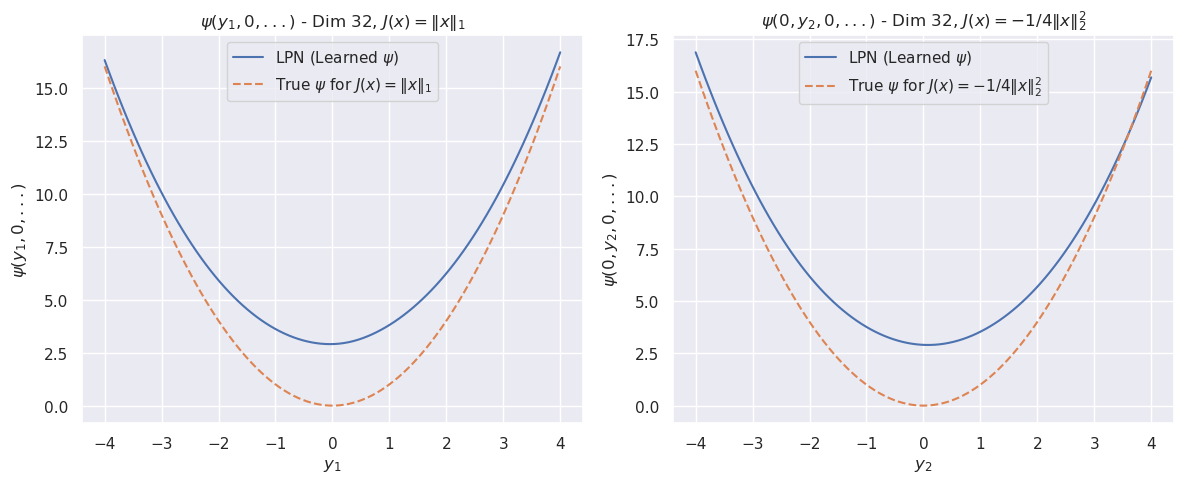

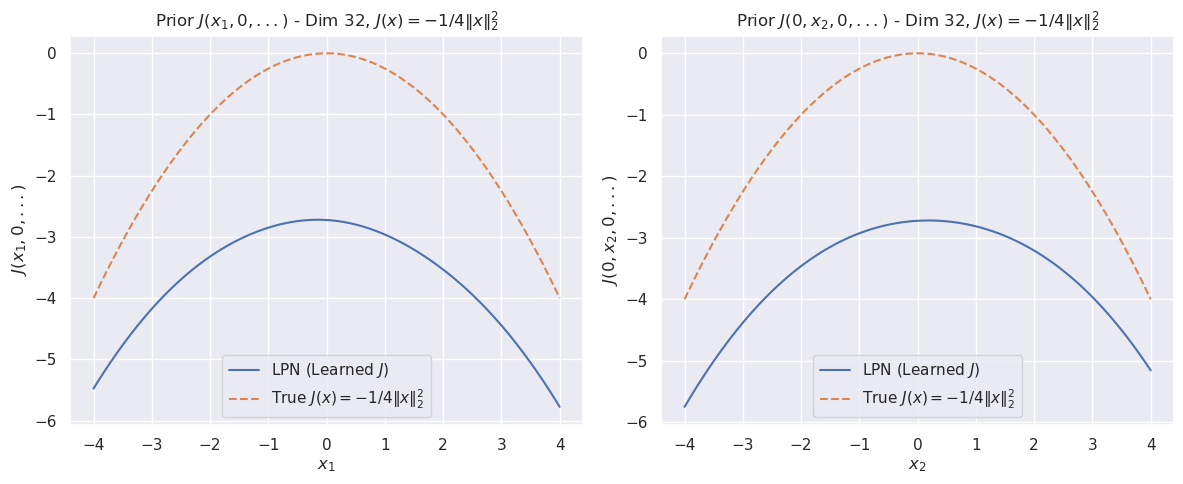

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.1519,  2.9007, -7.6109,  ...,  6.0386, -5.8782, -1.6489],
        [ 6.7824, -0.1231,  2.7810,  ..., -1.9040,  2.7254, -1.3706],
        [-7.6123,  1.2131,  2.5763,  ...,  0.8755, -1.4200, -4.4728],
        ...,
        [-5.6048,  5.1085,  7.1808,  ...,  0.2757,  0.5617,  0.4571],
        [ 0.1750, -6.2704,  5.5915,  ..., -3.0936, -2.4994,  6.0860],
        [-7.4747, -5.0087, -3.8291,  ..., -2.5477,  0.2301, -0.9441]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] /5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 27450.974609375
iteration 0 loss 10195.7041015625


iteration 500 loss 105.22354888916016


iteration 1000 loss 93.48812103271484


iteration 1500 loss 82.57495880126953


iteration 2000 loss 70.34434509277344


iteration 2500 loss 48.01823043823242


iteration 3000 loss 18.75749969482422


iteration 3500 loss 9.771040916442871


iteration 4000 loss 5.849299907684326


iteration 4500 loss 4.430916786193848


iteration 5000 loss 4.28405237197876


iteration 5500 loss 3.4542734622955322


iteration 6000 loss 2.9096930027008057


iteration 6500 loss 2.4532053470611572


iteration 7000 loss 2.899041175842285


iteration 7500 loss 2.2675888538360596


iteration 8000 loss 1.9963566064834595


iteration 8500 loss 1.7800428867340088


iteration 9000 loss 7.998432636260986


iteration 9500 loss 1.75865638256073


iteration 10000 loss 1.553542971611023


iteration 10500 loss 1.4141204357147217


iteration 11000 loss 1.2927851676940918


iteration 11500 loss 1.3055270910263062


iteration 12000 loss 1.1849178075790405


iteration 12500 loss 5.935224533081055


iteration 13000 loss 1.1374995708465576


iteration 13500 loss 1.0457521677017212


iteration 14000 loss 0.9772428274154663


iteration 14500 loss 1.044595718383789


iteration 15000 loss 0.9448193311691284


iteration 15500 loss 0.8866987824440002


iteration 16000 loss 0.9520274996757507


iteration 16500 loss 0.8447743058204651


iteration 17000 loss 0.7970481514930725


iteration 17500 loss 0.8615282773971558


iteration 18000 loss 0.7700225114822388


iteration 18500 loss 0.7293631434440613


iteration 19000 loss 0.8065317273139954


iteration 19500 loss 0.716925859451294


iteration 20000 loss 0.6795421838760376


iteration 20500 loss 0.7686248421669006


iteration 21000 loss 0.6637870669364929


iteration 21500 loss 0.6312052011489868


iteration 22000 loss 0.7210928797721863


iteration 22500 loss 0.6238083839416504


iteration 23000 loss 0.5932167768478394


iteration 23500 loss 0.5971168875694275


iteration 24000 loss 0.5629458427429199


iteration 24500 loss 0.5910914540290833


iteration 25000 loss 0.5474063754081726


iteration 25500 loss 19.76645851135254


iteration 26000 loss 0.5287003517150879


iteration 26500 loss 0.5078527927398682


iteration 27000 loss 0.502417266368866


iteration 27500 loss 0.5380853414535522


iteration 28000 loss 0.4833824932575226


iteration 28500 loss 0.49589911103248596


iteration 29000 loss 0.46227356791496277


iteration 29500 loss 0.4594832956790924


iteration 30000 loss 0.5256078243255615


iteration 30500 loss 0.44001784920692444


iteration 31000 loss 0.44278690218925476


iteration 31500 loss 0.6058052778244019


iteration 32000 loss 2.287288188934326


iteration 32500 loss 0.42187684774398804


iteration 33000 loss 0.41017860174179077


iteration 33500 loss 0.4135889410972595


iteration 34000 loss 0.3880160450935364


iteration 34500 loss 0.382250040769577


iteration 35000 loss 0.3851383626461029


iteration 35500 loss 0.49905556440353394


iteration 36000 loss 0.364006906747818


iteration 36500 loss 0.3580196797847748


iteration 37000 loss 0.38160809874534607


iteration 37500 loss 0.36233803629875183


iteration 38000 loss 0.3806433081626892


iteration 38500 loss 0.3471146821975708


iteration 39000 loss 0.33489173650741577


iteration 39500 loss 0.32717838883399963


iteration 40000 loss 0.4275834858417511


iteration 40500 loss 0.327288955450058


iteration 41000 loss 0.31435564160346985


iteration 41500 loss 0.3092429041862488


iteration 42000 loss 7.881864070892334


iteration 42500 loss 0.3039367198944092


iteration 43000 loss 0.2973599433898926


iteration 43500 loss 0.31157371401786804


iteration 44000 loss 0.29328611493110657


iteration 44500 loss 0.39140620827674866


iteration 45000 loss 0.28339684009552


iteration 45500 loss 0.2827359437942505


iteration 46000 loss 0.2771420478820801


iteration 46500 loss 0.3339614272117615


iteration 47000 loss 0.26987338066101074


iteration 47500 loss 0.2689456641674042


iteration 48000 loss 0.26984915137290955


iteration 48500 loss 0.26145869493484497


iteration 49000 loss 9.752097129821777


iteration 49500 loss 0.25540515780448914


iteration 50000 loss 0.3118678331375122


iteration 50500 loss 0.2487397938966751


iteration 51000 loss 0.2463720589876175


iteration 51500 loss 0.2473078966140747


iteration 52000 loss 0.24070625007152557


iteration 52500 loss 0.42607489228248596


iteration 53000 loss 0.23590154945850372


iteration 53500 loss 0.24454531073570251


iteration 54000 loss 0.23058123886585236


iteration 54500 loss 0.2541878819465637


iteration 55000 loss 0.22558964788913727


iteration 55500 loss 0.22619013488292694


iteration 56000 loss 0.7164782285690308


iteration 56500 loss 0.21897992491722107


iteration 57000 loss 0.21995648741722107


iteration 57500 loss 0.21651668846607208


iteration 58000 loss 0.21624906361103058


iteration 58500 loss 0.20961928367614746


iteration 59000 loss 0.21166813373565674


iteration 59500 loss 0.38378486037254333


iteration 60000 loss 0.20376171171665192


iteration 60500 loss 0.2041763812303543


iteration 61000 loss 0.19956882297992706


iteration 61500 loss 0.20415963232517242


iteration 62000 loss 0.19602033495903015


iteration 62500 loss 0.1948051005601883


iteration 63000 loss 0.4261557459831238


iteration 63500 loss 0.19143889844417572


iteration 64000 loss 0.19462847709655762


iteration 64500 loss 0.1868276745080948


iteration 65000 loss 0.18957945704460144


iteration 65500 loss 0.18402163684368134


iteration 66000 loss 0.18480141460895538


iteration 66500 loss 0.18209679424762726


iteration 67000 loss 0.1817997843027115


iteration 67500 loss 0.7013006806373596


iteration 68000 loss 0.17850381135940552


iteration 68500 loss 0.7543819546699524


iteration 69000 loss 0.1746692806482315


iteration 69500 loss 1.3110285997390747


iteration 70000 loss 0.1691332757472992


iteration 70500 loss 0.1686340570449829


iteration 71000 loss 0.4548632800579071


iteration 71500 loss 0.1649865359067917


iteration 72000 loss 0.16578829288482666


iteration 72500 loss 1.0346322059631348


iteration 73000 loss 0.5557618141174316


iteration 73500 loss 0.15984156727790833


iteration 74000 loss 0.16543304920196533


iteration 74500 loss 2.9349863529205322


iteration 75000 loss 0.15624304115772247


iteration 75500 loss 0.15678684413433075


iteration 76000 loss 0.9364462494850159


iteration 76500 loss 0.1522282361984253


iteration 77000 loss 0.15252389013767242


iteration 77500 loss 0.39594709873199463


iteration 78000 loss 0.14928530156612396


iteration 78500 loss 0.19205114245414734


iteration 79000 loss 0.1466532200574875


iteration 79500 loss 1.2741596698760986


iteration 80000 loss 0.1442674845457077


iteration 80500 loss 0.17204517126083374


iteration 81000 loss 0.14271433651447296


iteration 81500 loss 0.14535585045814514


iteration 82000 loss 0.13965635001659393


iteration 82500 loss 0.1382029801607132


iteration 83000 loss 0.13833175599575043


iteration 83500 loss 0.2856729030609131


iteration 84000 loss 0.13659851253032684


iteration 84500 loss 0.15202294290065765


iteration 85000 loss 1.3117954730987549


iteration 85500 loss 0.13237453997135162


iteration 86000 loss 0.13352346420288086


iteration 86500 loss 0.27706658840179443


iteration 87000 loss 0.1468713879585266


iteration 87500 loss 0.20067863166332245


iteration 88000 loss 0.1286664456129074


iteration 88500 loss 0.12902714312076569


iteration 89000 loss 0.8432673811912537


iteration 89500 loss 0.4497552514076233


iteration 90000 loss 0.2824953496456146


iteration 90500 loss 0.1342872679233551


iteration 91000 loss 0.1964329332113266


iteration 91500 loss 0.12197377532720566


iteration 92000 loss 0.12341313064098358


iteration 92500 loss 0.1828048676252365


iteration 93000 loss 0.12168337404727936


iteration 93500 loss 0.12078500539064407


iteration 94000 loss 0.12079978734254837


iteration 94500 loss 0.11697978526353836


iteration 95000 loss 0.11721096187829971


iteration 95500 loss 0.11549892276525497


iteration 96000 loss 0.13455714285373688


iteration 96500 loss 0.11425934731960297


iteration 97000 loss 0.15376970171928406


iteration 97500 loss 0.11344867944717407


iteration 98000 loss 0.6722091436386108


iteration 98500 loss 1.2030326128005981


iteration 99000 loss 0.32705995440483093


iteration 99500 loss 0.10977980494499207


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.11096647381782532


iteration 100500 loss 0.10873974114656448


iteration 101000 loss 0.10762333869934082


iteration 101500 loss 0.10679516196250916


iteration 102000 loss 0.10604981333017349


iteration 102500 loss 0.10529540479183197


iteration 103000 loss 0.1044781431555748


iteration 103500 loss 0.10356297343969345


iteration 104000 loss 0.1028544008731842


iteration 104500 loss 0.1024150401353836


iteration 105000 loss 0.10137888044118881


iteration 105500 loss 0.10071735829114914


iteration 106000 loss 0.09996647387742996


iteration 106500 loss 0.10304699093103409


iteration 107000 loss 0.09865060448646545


iteration 107500 loss 0.09808815270662308


iteration 108000 loss 0.09745943546295166


iteration 108500 loss 0.09954944998025894


iteration 109000 loss 0.09618131816387177


iteration 109500 loss 0.09560462087392807


iteration 110000 loss 0.09566372632980347


iteration 110500 loss 0.09442657232284546


iteration 111000 loss 0.09389783442020416


iteration 111500 loss 0.09331513196229935


iteration 112000 loss 0.09277282655239105


iteration 112500 loss 0.09226822108030319


iteration 113000 loss 0.09289933741092682


iteration 113500 loss 0.09117769449949265


iteration 114000 loss 0.09067437797784805


iteration 114500 loss 0.09017378836870193


iteration 115000 loss 0.0942889004945755


iteration 115500 loss 0.0991295650601387


iteration 116000 loss 0.08866526931524277


iteration 116500 loss 0.08888725191354752


iteration 117000 loss 0.08839289098978043


iteration 117500 loss 0.08723144233226776


iteration 118000 loss 0.0895395502448082


iteration 118500 loss 0.0862923115491867


iteration 119000 loss 0.08593744039535522


iteration 119500 loss 0.08603542298078537


iteration 120000 loss 0.0849672257900238


iteration 120500 loss 0.08449985086917877


iteration 121000 loss 0.08407755941152573


iteration 121500 loss 0.08364594727754593


iteration 122000 loss 0.08330576866865158


iteration 122500 loss 0.0922083929181099


iteration 123000 loss 0.08237894624471664


iteration 123500 loss 0.08196641504764557


iteration 124000 loss 0.08175325393676758


iteration 124500 loss 0.08344580233097076


iteration 125000 loss 0.0807594284415245


iteration 125500 loss 0.08044668287038803


iteration 126000 loss 0.08014240860939026


iteration 126500 loss 0.08055798709392548


iteration 127000 loss 0.07921838015317917


iteration 127500 loss 0.07918883115053177


iteration 128000 loss 0.07849559187889099


iteration 128500 loss 0.07813267409801483


iteration 129000 loss 0.0780315026640892


iteration 129500 loss 0.0786995217204094


iteration 130000 loss 0.07709106057882309


iteration 130500 loss 0.07671758532524109


iteration 131000 loss 0.07638463377952576


iteration 131500 loss 0.07601787894964218


iteration 132000 loss 0.07579635828733444


iteration 132500 loss 0.07535047084093094


iteration 133000 loss 0.07504355162382126


iteration 133500 loss 0.09845055639743805


iteration 134000 loss 0.3281119167804718


iteration 134500 loss 0.07748061418533325


iteration 135000 loss 0.073711097240448


iteration 135500 loss 0.07336165010929108


iteration 136000 loss 0.0730714201927185


iteration 136500 loss 0.07276153564453125


iteration 137000 loss 0.0724535658955574


iteration 137500 loss 0.07238105684518814


iteration 138000 loss 0.07187840342521667


iteration 138500 loss 0.07152896374464035


iteration 139000 loss 0.07286463677883148


iteration 139500 loss 0.07093740254640579


iteration 140000 loss 0.07067011296749115


iteration 140500 loss 0.07298269122838974


iteration 141000 loss 0.07007335126399994


iteration 141500 loss 0.06977681815624237


iteration 142000 loss 0.06948626786470413


iteration 142500 loss 0.0692163035273552


iteration 143000 loss 0.06899409741163254


iteration 143500 loss 0.06863481551408768


iteration 144000 loss 0.06837828457355499


iteration 144500 loss 0.06821413338184357


iteration 145000 loss 0.06785070896148682


iteration 145500 loss 0.06758559495210648


iteration 146000 loss 0.06821634620428085


iteration 146500 loss 0.06773059070110321


iteration 147000 loss 0.06679315865039825


iteration 147500 loss 0.06658545881509781


iteration 148000 loss 0.0672285333275795


iteration 148500 loss 0.06604086607694626


iteration 149000 loss 0.0857953205704689


iteration 149500 loss 0.06552355736494064


iteration 150000 loss 0.06526996940374374


iteration 150500 loss 0.0650426521897316


iteration 151000 loss 0.2422729879617691


iteration 151500 loss 0.06453860551118851


iteration 152000 loss 0.0643186867237091


iteration 152500 loss 0.06546010822057724


iteration 153000 loss 0.06380168348550797


iteration 153500 loss 0.06357473134994507


iteration 154000 loss 0.06336355954408646


iteration 154500 loss 0.26897329092025757


iteration 155000 loss 0.06333853304386139


iteration 155500 loss 0.0626445785164833


iteration 156000 loss 0.06256633251905441


iteration 156500 loss 0.06221482530236244


iteration 157000 loss 0.06196695566177368


iteration 157500 loss 0.06457722932100296


iteration 158000 loss 0.062535360455513


iteration 158500 loss 0.061314623802900314


iteration 159000 loss 0.0611608512699604


iteration 159500 loss 0.06084350496530533


iteration 160000 loss 0.06066584214568138


iteration 160500 loss 0.06044808030128479


iteration 161000 loss 0.060228295624256134


iteration 161500 loss 0.0601319819688797


iteration 162000 loss 0.06019710376858711


iteration 162500 loss 0.059611156582832336


iteration 163000 loss 0.059452977031469345


iteration 163500 loss 0.059208523482084274


iteration 164000 loss 0.05904791131615639


iteration 164500 loss 0.05881056189537048


iteration 165000 loss 0.058618590235710144


iteration 165500 loss 0.05862458422780037


iteration 166000 loss 0.058243345469236374


iteration 166500 loss 0.05814247205853462


iteration 167000 loss 0.05784079432487488


iteration 167500 loss 0.05765378102660179


iteration 168000 loss 0.05748046189546585


iteration 168500 loss 0.05738317593932152


iteration 169000 loss 0.05945662036538124


iteration 169500 loss 0.05690617486834526


iteration 170000 loss 0.05671364441514015


iteration 170500 loss 0.05656813830137253


iteration 171000 loss 0.056376975029706955


iteration 171500 loss 0.05627279356122017


iteration 172000 loss 0.05597425997257233


iteration 172500 loss 0.05581367015838623


iteration 173000 loss 0.055622607469558716


iteration 173500 loss 0.05548954755067825


iteration 174000 loss 0.08044273406267166


iteration 174500 loss 0.05506676062941551


iteration 175000 loss 0.05491308495402336


iteration 175500 loss 0.054858073592185974


iteration 176000 loss 0.05454330891370773


iteration 176500 loss 0.05457276478409767


iteration 177000 loss 0.05427350848913193


iteration 177500 loss 0.05612346529960632


iteration 178000 loss 0.05389943718910217


iteration 178500 loss 0.053766246885061264


iteration 179000 loss 0.05355070158839226


iteration 179500 loss 0.05339266359806061


iteration 180000 loss 0.06058745086193085


iteration 180500 loss 0.05305585637688637


iteration 181000 loss 0.05288693681359291


iteration 181500 loss 0.05272467061877251


iteration 182000 loss 0.052565060555934906


iteration 182500 loss 0.05550280585885048


iteration 183000 loss 0.052261997014284134


iteration 183500 loss 0.08428209275007248


iteration 184000 loss 0.05202203243970871


iteration 184500 loss 0.05178461968898773


iteration 185000 loss 0.05166371166706085


iteration 185500 loss 2.0791735649108887


iteration 186000 loss 0.06484513729810715


iteration 186500 loss 0.051157157868146896


iteration 187000 loss 0.051009152084589005


iteration 187500 loss 0.05087626352906227


iteration 188000 loss 0.12643852829933167


iteration 188500 loss 0.050556983798742294


iteration 189000 loss 0.05044906213879585


iteration 189500 loss 1.5564489364624023


iteration 190000 loss 0.050153233110904694


iteration 190500 loss 0.04995739459991455


iteration 191000 loss 0.04984155669808388


iteration 191500 loss 0.4795307517051697


iteration 192000 loss 0.049518465995788574


iteration 192500 loss 0.04953235760331154


iteration 193000 loss 0.049247775226831436


iteration 193500 loss 0.04929441586136818


iteration 194000 loss 0.04897215589880943


iteration 194500 loss 0.04888944700360298


iteration 195000 loss 0.0486837774515152


iteration 195500 loss 0.04874322935938835


iteration 196000 loss 0.048414818942546844


iteration 196500 loss 0.04829100891947746


iteration 197000 loss 0.04824637249112129


iteration 197500 loss 0.0479932501912117


iteration 198000 loss 0.06424279510974884


iteration 198500 loss 0.047729477286338806


iteration 199000 loss 0.047602392733097076


iteration 199500 loss 0.04754592105746269


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.047340940684080124


iteration 200500 loss 0.04727883264422417


iteration 201000 loss 0.04723387584090233


iteration 201500 loss 0.047176897525787354


iteration 202000 loss 0.04710434004664421


iteration 202500 loss 0.047011833637952805


iteration 203000 loss 0.04689378663897514


iteration 203500 loss 0.04679775983095169


iteration 204000 loss 0.04663714021444321


iteration 204500 loss 0.046545300632715225


iteration 205000 loss 0.046430278569459915


iteration 205500 loss 0.046273600310087204


iteration 206000 loss 0.046168603003025055


iteration 206500 loss 0.04604078456759453


iteration 207000 loss 0.045907311141490936


iteration 207500 loss 0.045804377645254135


iteration 208000 loss 0.0458645336329937


iteration 208500 loss 0.04554946348071098


iteration 209000 loss 0.04544813185930252


iteration 209500 loss 0.04535585641860962


iteration 210000 loss 0.0452447310090065


iteration 210500 loss 0.04511520266532898


iteration 211000 loss 0.04500573128461838


iteration 211500 loss 0.04497798532247543


iteration 212000 loss 0.04476570338010788


iteration 212500 loss 0.044673606753349304


iteration 213000 loss 0.044560473412275314


iteration 213500 loss 0.04667980223894119


iteration 214000 loss 0.04433134198188782


iteration 214500 loss 0.04428475350141525


iteration 215000 loss 0.04545844718813896


iteration 215500 loss 0.04399191960692406


iteration 216000 loss 0.04389065504074097


iteration 216500 loss 0.04500859975814819


iteration 217000 loss 0.04365893825888634


iteration 217500 loss 0.043572746217250824


iteration 218000 loss 0.04348784685134888


iteration 218500 loss 0.04333309829235077


iteration 219000 loss 0.04325241968035698


iteration 219500 loss 0.04315898194909096


iteration 220000 loss 0.04310314357280731


iteration 220500 loss 0.0429399348795414


iteration 221000 loss 0.04284273087978363


iteration 221500 loss 0.04278551787137985


iteration 222000 loss 0.042618200182914734


iteration 222500 loss 0.04252665862441063


iteration 223000 loss 0.04242667555809021


iteration 223500 loss 0.042312487959861755


iteration 224000 loss 0.042265281081199646


iteration 224500 loss 0.04219081997871399


iteration 225000 loss 0.042001962661743164


iteration 225500 loss 0.04190662503242493


iteration 226000 loss 0.13756823539733887


iteration 226500 loss 0.041695401072502136


iteration 227000 loss 0.04159795492887497


iteration 227500 loss 0.041480064392089844


iteration 228000 loss 0.04140041396021843


iteration 228500 loss 0.04131481796503067


iteration 229000 loss 0.04125063493847847


iteration 229500 loss 0.0411040373146534


iteration 230000 loss 0.041016630828380585


iteration 230500 loss 0.04092429205775261


iteration 231000 loss 0.04081595316529274


iteration 231500 loss 0.04072776064276695


iteration 232000 loss 0.04062813147902489


iteration 232500 loss 0.04052506014704704


iteration 233000 loss 0.04044002667069435


iteration 233500 loss 0.04034291207790375


iteration 234000 loss 0.040238384157419205


iteration 234500 loss 0.04015776142477989


iteration 235000 loss 0.04006200656294823


iteration 235500 loss 0.04002075642347336


iteration 236000 loss 0.03987967595458031


iteration 236500 loss 0.03980260342359543


iteration 237000 loss 0.039748869836330414


iteration 237500 loss 0.039610717445611954


iteration 238000 loss 0.03953034430742264


iteration 238500 loss 0.03943033516407013


iteration 239000 loss 0.03933580964803696


iteration 239500 loss 0.03925454244017601


iteration 240000 loss 0.039671238511800766


iteration 240500 loss 0.03906373679637909


iteration 241000 loss 0.03898255154490471


iteration 241500 loss 0.03895759955048561


iteration 242000 loss 0.038812048733234406


iteration 242500 loss 0.03872043266892433


iteration 243000 loss 0.038742680102586746


iteration 243500 loss 0.03851943835616112


iteration 244000 loss 0.03844892606139183


iteration 244500 loss 0.03836915269494057


iteration 245000 loss 0.03828108310699463


iteration 245500 loss 0.03819284588098526


iteration 246000 loss 0.03810909390449524


iteration 246500 loss 0.03801270201802254


iteration 247000 loss 0.03793196380138397


iteration 247500 loss 0.03785034641623497


iteration 248000 loss 0.037766654044389725


iteration 248500 loss 0.03767504170536995


iteration 249000 loss 0.03759606182575226


iteration 249500 loss 0.07142539322376251


iteration 250000 loss 0.03742412477731705


iteration 250500 loss 0.037385739386081696


iteration 251000 loss 0.037249088287353516


iteration 251500 loss 0.03718094155192375


iteration 252000 loss 0.03710242733359337


iteration 252500 loss 0.03799969330430031


iteration 253000 loss 0.03693900629878044


iteration 253500 loss 0.036872074007987976


iteration 254000 loss 0.03678177297115326


iteration 254500 loss 0.03669983893632889


iteration 255000 loss 0.036716967821121216


iteration 255500 loss 0.03787388652563095


iteration 256000 loss 0.03646250069141388


iteration 256500 loss 0.036435797810554504


iteration 257000 loss 0.036392081528902054


iteration 257500 loss 0.036219384521245956


iteration 258000 loss 0.03615184128284454


iteration 258500 loss 0.03607800975441933


iteration 259000 loss 0.03599116578698158


iteration 259500 loss 0.035920605063438416


iteration 260000 loss 0.03607633709907532


iteration 260500 loss 0.035760875791311264


iteration 261000 loss 0.03569862246513367


iteration 261500 loss 0.03576141223311424


iteration 262000 loss 0.03555903211236


iteration 262500 loss 0.0354686863720417


iteration 263000 loss 0.03571747988462448


iteration 263500 loss 0.03531138598918915


iteration 264000 loss 0.03524532541632652


iteration 264500 loss 0.035243600606918335


iteration 265000 loss 0.0350920632481575


iteration 265500 loss 0.035083312541246414


iteration 266000 loss 0.03494594618678093


iteration 266500 loss 0.034874726086854935


iteration 267000 loss 0.03480919077992439


iteration 267500 loss 0.03472840040922165


iteration 268000 loss 0.034653473645448685


iteration 268500 loss 0.03459098935127258


iteration 269000 loss 0.0345722995698452


iteration 269500 loss 0.034443072974681854


iteration 270000 loss 0.03437988832592964


iteration 270500 loss 0.03430972248315811


iteration 271000 loss 0.07751458883285522


iteration 271500 loss 0.034170158207416534


iteration 272000 loss 0.034113191068172455


iteration 272500 loss 0.03404195234179497


iteration 273000 loss 0.033969372510910034


iteration 273500 loss 0.03390917927026749


iteration 274000 loss 0.03496652841567993


iteration 274500 loss 0.03376508876681328


iteration 275000 loss 0.03370344266295433


iteration 275500 loss 0.03396161273121834


iteration 276000 loss 0.03356512263417244


iteration 276500 loss 0.03350277617573738


iteration 277000 loss 0.03344257175922394


iteration 277500 loss 0.033403221517801285


iteration 278000 loss 0.033301178365945816


iteration 278500 loss 0.03323871269822121


iteration 279000 loss 0.03352798894047737


iteration 279500 loss 0.03310031071305275


iteration 280000 loss 0.033053990453481674


iteration 280500 loss 0.032988373190164566


iteration 281000 loss 0.03290286660194397


iteration 281500 loss 0.032831769436597824


iteration 282000 loss 0.03276780620217323


iteration 282500 loss 0.03270871937274933


iteration 283000 loss 0.03294534981250763


iteration 283500 loss 0.03257778659462929


iteration 284000 loss 0.032536011189222336


iteration 284500 loss 0.03245176374912262


iteration 285000 loss 0.03238455206155777


iteration 285500 loss 0.03233591094613075


iteration 286000 loss 0.03230906277894974


iteration 286500 loss 0.03226587921380997


iteration 287000 loss 0.03214671462774277


iteration 287500 loss 0.032175153493881226


iteration 288000 loss 0.03204163908958435


iteration 288500 loss 0.031956180930137634


iteration 289000 loss 0.03189915791153908


iteration 289500 loss 0.03182857483625412


iteration 290000 loss 0.031767163425683975


iteration 290500 loss 0.0317169651389122


iteration 291000 loss 0.03179965913295746


iteration 291500 loss 0.03175216168165207


iteration 292000 loss 0.0315362811088562


iteration 292500 loss 0.03147698566317558


iteration 293000 loss 0.031412553042173386


iteration 293500 loss 0.031358134001493454


iteration 294000 loss 0.03135853260755539


iteration 294500 loss 0.031238775700330734


iteration 295000 loss 0.031183822080492973


iteration 295500 loss 0.031313687562942505


iteration 296000 loss 0.03723505884408951


iteration 296500 loss 0.031006500124931335


iteration 297000 loss 0.03220963105559349


iteration 297500 loss 0.030891014263033867


iteration 298000 loss 0.030836332589387894


iteration 298500 loss 0.030783113092184067


iteration 299000 loss 0.03080742433667183


iteration 299500 loss 0.030662432312965393


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.03061550483107567


iteration 300500 loss 0.030604083091020584


iteration 301000 loss 0.030589457601308823


iteration 301500 loss 0.030570540577173233


iteration 302000 loss 0.030546266585588455


iteration 302500 loss 0.030515156686306


iteration 303000 loss 0.030475230887532234


iteration 303500 loss 0.030424023047089577


iteration 304000 loss 0.03036467730998993


iteration 304500 loss 0.030279042199254036


iteration 305000 loss 0.030229588970541954


iteration 305500 loss 0.03019455447793007


iteration 306000 loss 0.030149715021252632


iteration 306500 loss 0.030097929760813713


iteration 307000 loss 0.03002483770251274


iteration 307500 loss 0.029944512993097305


iteration 308000 loss 0.029914412647485733


iteration 308500 loss 0.029877837747335434


iteration 309000 loss 0.029832372441887856


iteration 309500 loss 0.029783891513943672


iteration 310000 loss 0.029698219150304794


iteration 310500 loss 0.029637090861797333


iteration 311000 loss 0.029606522992253304


iteration 311500 loss 0.02956748567521572


iteration 312000 loss 0.029523979872465134


iteration 312500 loss 0.029460033401846886


iteration 313000 loss 0.029381707310676575


iteration 313500 loss 0.029330769553780556


iteration 314000 loss 0.029290959239006042


iteration 314500 loss 0.02924184501171112


iteration 315000 loss 0.02917693741619587


iteration 315500 loss 0.029102375730872154


iteration 316000 loss 0.029058683663606644


iteration 316500 loss 0.029027031734585762


iteration 317000 loss 0.028986547142267227


iteration 317500 loss 0.028935186564922333


iteration 318000 loss 0.02887609787285328


iteration 318500 loss 0.02879335545003414


iteration 319000 loss 0.028759658336639404


iteration 319500 loss 0.02872699499130249


iteration 320000 loss 0.028690457344055176


iteration 320500 loss 0.02863304316997528


iteration 321000 loss 0.02856728434562683


iteration 321500 loss 0.02849476784467697


iteration 322000 loss 0.0284628476947546


iteration 322500 loss 0.0284263975918293


iteration 323000 loss 0.028379952535033226


iteration 323500 loss 0.028330907225608826


iteration 324000 loss 0.028248198330402374


iteration 324500 loss 0.02820657193660736


iteration 325000 loss 0.02817750722169876


iteration 325500 loss 0.028140230104327202


iteration 326000 loss 0.028095155954360962


iteration 326500 loss 0.02803892083466053


iteration 327000 loss 0.02795785665512085


iteration 327500 loss 0.02792557328939438


iteration 328000 loss 0.02789255976676941


iteration 328500 loss 0.027852574363350868


iteration 329000 loss 0.027804449200630188


iteration 329500 loss 0.02773655392229557


iteration 330000 loss 0.027682127431035042


iteration 330500 loss 0.027648936957120895


iteration 331000 loss 0.02760664001107216


iteration 331500 loss 0.027560638263821602


iteration 332000 loss 0.02748968079686165


iteration 332500 loss 0.027436260133981705


iteration 333000 loss 0.027401156723499298


iteration 333500 loss 0.027357909828424454


iteration 334000 loss 0.027304260060191154


iteration 334500 loss 0.02722850628197193


iteration 335000 loss 0.027189448475837708


iteration 335500 loss 0.027155248448252678


iteration 336000 loss 0.027120491489768028


iteration 336500 loss 0.02705661579966545


iteration 337000 loss 0.026990819722414017


iteration 337500 loss 0.026951707899570465


iteration 338000 loss 0.026922008022665977


iteration 338500 loss 0.02688971534371376


iteration 339000 loss 0.02683618664741516


iteration 339500 loss 0.02677582949399948


iteration 340000 loss 0.02671908587217331


iteration 340500 loss 0.026692327111959457


iteration 341000 loss 0.026658153161406517


iteration 341500 loss 0.026615368202328682


iteration 342000 loss 0.02657545730471611


iteration 342500 loss 0.026497438549995422


iteration 343000 loss 0.026463927701115608


iteration 343500 loss 0.02643396519124508


iteration 344000 loss 0.026395626366138458


iteration 344500 loss 0.02634849213063717


iteration 345000 loss 0.026297595351934433


iteration 345500 loss 0.026232708245515823


iteration 346000 loss 0.026202276349067688


iteration 346500 loss 0.02616472728550434


iteration 347000 loss 0.02611577697098255


iteration 347500 loss 0.026052294299006462


iteration 348000 loss 0.02600839175283909


iteration 348500 loss 0.02597583271563053


iteration 349000 loss 0.025935927405953407


iteration 349500 loss 0.025881579145789146


iteration 350000 loss 0.025849822908639908


iteration 350500 loss 0.02577909268438816


iteration 351000 loss 0.02574804052710533


iteration 351500 loss 0.02570870891213417


iteration 352000 loss 0.025658782571554184


iteration 352500 loss 0.02559483051300049


iteration 353000 loss 0.02555496245622635


iteration 353500 loss 0.025524575263261795


iteration 354000 loss 0.025487732142210007


iteration 354500 loss 0.02544124610722065


iteration 355000 loss 0.025376928970217705


iteration 355500 loss 0.025337954983115196


iteration 356000 loss 0.0253117848187685


iteration 356500 loss 0.025278234854340553


iteration 357000 loss 0.025237368419766426


iteration 357500 loss 0.025187399238348007


iteration 358000 loss 0.02512638457119465


iteration 358500 loss 0.02510426752269268


iteration 359000 loss 0.02507820352911949


iteration 359500 loss 0.025046132504940033


iteration 360000 loss 0.025004452094435692


iteration 360500 loss 0.02495606243610382


iteration 361000 loss 0.024901876226067543


iteration 361500 loss 0.024879008531570435


iteration 362000 loss 0.02484985627233982


iteration 362500 loss 0.02482333593070507


iteration 363000 loss 0.024774814024567604


iteration 363500 loss 0.024708494544029236


iteration 364000 loss 0.024666547775268555


iteration 364500 loss 0.024640753865242004


iteration 365000 loss 0.02461010403931141


iteration 365500 loss 0.024567140266299248


iteration 366000 loss 0.024514587596058846


iteration 366500 loss 0.024461135268211365


iteration 367000 loss 0.024441158398985863


iteration 367500 loss 0.024416474625468254


iteration 368000 loss 0.024386398494243622


iteration 368500 loss 0.02434869110584259


iteration 369000 loss 0.024294665083289146


iteration 369500 loss 0.02457587793469429


iteration 370000 loss 0.024213233962655067


iteration 370500 loss 0.024187250062823296


iteration 371000 loss 0.0241558700799942


iteration 371500 loss 0.024112844839692116


iteration 372000 loss 0.024060573428869247


iteration 372500 loss 0.02401367574930191


iteration 373000 loss 0.02398875169456005


iteration 373500 loss 0.02395782805979252


iteration 374000 loss 0.023927588015794754


iteration 374500 loss 0.02386704832315445


iteration 375000 loss 0.02381528541445732


iteration 375500 loss 0.02379285916686058


iteration 376000 loss 0.023764964193105698


iteration 376500 loss 0.02373015508055687


iteration 377000 loss 0.0236858818680048


iteration 377500 loss 0.023651456460356712


iteration 378000 loss 0.023603010922670364


iteration 378500 loss 0.023581191897392273


iteration 379000 loss 0.02355337142944336


iteration 379500 loss 0.023523155599832535


iteration 380000 loss 0.023474477231502533


iteration 380500 loss 0.023952636867761612


iteration 381000 loss 0.023395787924528122


iteration 381500 loss 0.023367488756775856


iteration 382000 loss 0.02333289012312889


iteration 382500 loss 0.023288115859031677


iteration 383000 loss 0.02323256805539131


iteration 383500 loss 0.023209156468510628


iteration 384000 loss 0.023187337443232536


iteration 384500 loss 0.023159610107541084


iteration 385000 loss 0.023126116022467613


iteration 385500 loss 0.023083949461579323


iteration 386000 loss 0.02310207486152649


iteration 386500 loss 0.023006752133369446


iteration 387000 loss 0.022984711453318596


iteration 387500 loss 0.022958694025874138


iteration 388000 loss 0.02292194589972496


iteration 388500 loss 0.022875703871250153


iteration 389000 loss 0.02670639008283615


iteration 389500 loss 0.022802196443080902


iteration 390000 loss 0.022780297324061394


iteration 390500 loss 0.022754857316613197


iteration 391000 loss 0.022718358784914017


iteration 391500 loss 0.022671837359666824


iteration 392000 loss 0.022626716643571854


iteration 392500 loss 0.02260839380323887


iteration 393000 loss 0.02258586697280407


iteration 393500 loss 0.022558113560080528


iteration 394000 loss 0.022523200139403343


iteration 394500 loss 0.022475222125649452


iteration 395000 loss 0.022432347759604454


iteration 395500 loss 0.02240891382098198


iteration 396000 loss 0.022379420697689056


iteration 396500 loss 0.022341405972838402


iteration 397000 loss 0.022297097370028496


iteration 397500 loss 0.02226070873439312


iteration 398000 loss 0.022241972386837006


iteration 398500 loss 0.022218050435185432


iteration 399000 loss 0.022188542410731316


iteration 399500 loss 0.022152245044708252


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 0.022100239992141724


iteration 400500 loss 0.02208756096661091


iteration 401000 loss 0.022071709856390953


iteration 401500 loss 0.022051360458135605


iteration 402000 loss 0.022025277838110924


iteration 402500 loss 0.021991921588778496


iteration 403000 loss 0.021949391812086105


iteration 403500 loss 0.02193019725382328


iteration 404000 loss 0.021864596754312515


iteration 404500 loss 0.02182561159133911


iteration 405000 loss 0.021776385605335236


iteration 405500 loss 0.02173846773803234


iteration 406000 loss 0.021708441898226738


iteration 406500 loss 0.021670250222086906


iteration 407000 loss 0.02162240631878376


iteration 407500 loss 0.021584194153547287


iteration 408000 loss 0.021554062142968178


iteration 408500 loss 0.02151576802134514


iteration 409000 loss 0.021467894315719604


iteration 409500 loss 0.021432580426335335


iteration 410000 loss 0.021403204649686813


iteration 410500 loss 0.021366022527217865


iteration 411000 loss 0.02131936512887478


iteration 411500 loss 0.021280204877257347


iteration 412000 loss 0.021247955039143562


iteration 412500 loss 0.02120736427605152


iteration 413000 loss 0.02133425511419773


iteration 413500 loss 0.021130651235580444


iteration 414000 loss 0.021097911521792412


iteration 414500 loss 0.02105613984167576


iteration 415000 loss 0.021009325981140137


iteration 415500 loss 0.0209845919162035


iteration 416000 loss 0.020953044295310974


iteration 416500 loss 0.020913219079375267


iteration 417000 loss 0.02086370252072811


iteration 417500 loss 0.02083919756114483


iteration 418000 loss 0.020809801295399666


iteration 418500 loss 0.020772486925125122


iteration 419000 loss 0.020725876092910767


iteration 419500 loss 0.02069629356265068


iteration 420000 loss 0.020669877529144287


iteration 420500 loss 0.020636431872844696


iteration 421000 loss 0.020594093948602676


iteration 421500 loss 0.020550670102238655


iteration 422000 loss 0.020525461062788963


iteration 422500 loss 0.0204934012144804


iteration 423000 loss 0.02045299857854843


iteration 423500 loss 0.020410461351275444


iteration 424000 loss 0.020380981266498566


iteration 424500 loss 0.020343665033578873


iteration 425000 loss 0.020297152921557426


iteration 425500 loss 0.020272931084036827


iteration 426000 loss 0.020247183740139008


iteration 426500 loss 0.020214878022670746


iteration 427000 loss 0.020174311473965645


iteration 427500 loss 0.02013523317873478


iteration 428000 loss 0.020110424607992172


iteration 428500 loss 0.02007891796529293


iteration 429000 loss 0.02003917098045349


iteration 429500 loss 0.019997773692011833


iteration 430000 loss 0.01997036673128605


iteration 430500 loss 0.019935602322220802


iteration 431000 loss 0.019891994073987007


iteration 431500 loss 0.01986091211438179


iteration 432000 loss 0.019828766584396362


iteration 432500 loss 0.01978817954659462


iteration 433000 loss 0.019752617925405502


iteration 433500 loss 0.019729753956198692


iteration 434000 loss 0.0197005532681942


iteration 434500 loss 0.01966368593275547


iteration 435000 loss 0.019624264910817146


iteration 435500 loss 0.01959764026105404


iteration 436000 loss 0.019570495933294296


iteration 436500 loss 0.019536297768354416


iteration 437000 loss 0.019493285566568375


iteration 437500 loss 0.01946786791086197


iteration 438000 loss 0.019444957375526428


iteration 438500 loss 0.01941588707268238


iteration 439000 loss 0.01937919482588768


iteration 439500 loss 0.019336678087711334


iteration 440000 loss 0.019314086064696312


iteration 440500 loss 0.019285360351204872


iteration 441000 loss 0.019249029457569122


iteration 441500 loss 0.019209634512662888


iteration 442000 loss 0.019189316779375076


iteration 442500 loss 0.019163310527801514


iteration 443000 loss 0.01913047954440117


iteration 443500 loss 0.01908920519053936


iteration 444000 loss 0.01906452886760235


iteration 444500 loss 0.019040286540985107


iteration 445000 loss 0.01900974102318287


iteration 445500 loss 0.018971141427755356


iteration 446000 loss 0.01894015446305275


iteration 446500 loss 0.01892009750008583


iteration 447000 loss 0.0188945010304451


iteration 447500 loss 0.018862716853618622


iteration 448000 loss 0.018821438774466515


iteration 448500 loss 0.018798019737005234


iteration 449000 loss 0.018775975331664085


iteration 449500 loss 0.01874816231429577


iteration 450000 loss 0.01871260069310665


iteration 450500 loss 0.018675671890378


iteration 451000 loss 0.018655972555279732


iteration 451500 loss 0.018630705773830414


iteration 452000 loss 0.018598830327391624


iteration 452500 loss 0.018558815121650696


iteration 453000 loss 0.018536174669861794


iteration 453500 loss 0.01851499080657959


iteration 454000 loss 0.018488053232431412


iteration 454500 loss 0.018454009667038918


iteration 455000 loss 0.018417228013277054


iteration 455500 loss 0.018397564068436623


iteration 456000 loss 0.018372615799307823


iteration 456500 loss 0.018340880051255226


iteration 457000 loss 0.01830146461725235


iteration 457500 loss 0.01828153058886528


iteration 458000 loss 0.01825980842113495


iteration 458500 loss 0.018232204020023346


iteration 459000 loss 0.0181976780295372


iteration 459500 loss 0.018164129927754402


iteration 460000 loss 0.018145160749554634


iteration 460500 loss 0.0181210208684206


iteration 461000 loss 0.01809014193713665


iteration 461500 loss 0.0180517490953207


iteration 462000 loss 0.018028728663921356


iteration 462500 loss 0.018003592267632484


iteration 463000 loss 0.017971927300095558


iteration 463500 loss 0.017937922850251198


iteration 464000 loss 0.017912644892930984


iteration 464500 loss 0.017887117341160774


iteration 465000 loss 0.017854753881692886


iteration 465500 loss 0.017820153385400772


iteration 466000 loss 0.017800182104110718


iteration 466500 loss 0.017774807289242744


iteration 467000 loss 0.01774282194674015


iteration 467500 loss 0.017708495259284973


iteration 468000 loss 0.01768854632973671


iteration 468500 loss 0.017663544043898582


iteration 469000 loss 0.01763111539185047


iteration 469500 loss 0.01759631559252739


iteration 470000 loss 0.017580382525920868


iteration 470500 loss 0.017560027539730072


iteration 471000 loss 0.017534151673316956


iteration 471500 loss 0.01750175468623638


iteration 472000 loss 0.01747056096792221


iteration 472500 loss 0.017450522631406784


iteration 473000 loss 0.01742503046989441


iteration 473500 loss 0.01739376038312912


iteration 474000 loss 0.017362887039780617


iteration 474500 loss 0.01734590157866478


iteration 475000 loss 0.017324168235063553


iteration 475500 loss 0.017296817153692245


iteration 476000 loss 0.01726246438920498


iteration 476500 loss 0.017239196226000786


iteration 477000 loss 0.017221838235855103


iteration 477500 loss 0.017199743539094925


iteration 478000 loss 0.017171813175082207


iteration 478500 loss 0.017136797308921814


iteration 479000 loss 0.01711534708738327


iteration 479500 loss 0.017093349248170853


iteration 480000 loss 0.017065679654479027


iteration 480500 loss 0.017030464485287666


iteration 481000 loss 0.017012780532240868


iteration 481500 loss 0.016993554309010506


iteration 482000 loss 0.0169695932418108


iteration 482500 loss 0.016938690096139908


iteration 483000 loss 0.01690780557692051


iteration 483500 loss 0.016893092542886734


iteration 484000 loss 0.016874181106686592


iteration 484500 loss 0.016850454732775688


iteration 485000 loss 0.016820000484585762


iteration 485500 loss 0.016790395602583885


iteration 486000 loss 0.016773462295532227


iteration 486500 loss 0.01675201766192913


iteration 487000 loss 0.016724493354558945


iteration 487500 loss 0.016690466552972794


iteration 488000 loss 0.01667194440960884


iteration 488500 loss 0.016650095582008362


iteration 489000 loss 0.01662246324121952


iteration 489500 loss 0.016646040603518486


iteration 490000 loss 0.016572564840316772


iteration 490500 loss 0.016552524641156197


iteration 491000 loss 0.01652689091861248


iteration 491500 loss 0.016495205461978912


iteration 492000 loss 0.016474636271595955


iteration 492500 loss 0.01645793952047825


iteration 493000 loss 0.016436737030744553


iteration 493500 loss 0.01641005463898182


iteration 494000 loss 0.016376057639718056


iteration 494500 loss 0.016361359506845474


iteration 495000 loss 0.01634557545185089


iteration 495500 loss 0.01632542721927166


iteration 496000 loss 0.016300005838274956


iteration 496500 loss 0.016268035396933556


iteration 497000 loss 0.016248688101768494


iteration 497500 loss 0.016230231150984764


iteration 498000 loss 0.016206789761781693


iteration 498500 loss 0.01617719978094101


iteration 499000 loss 0.016151852905750275


iteration 499500 loss 0.016132637858390808


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


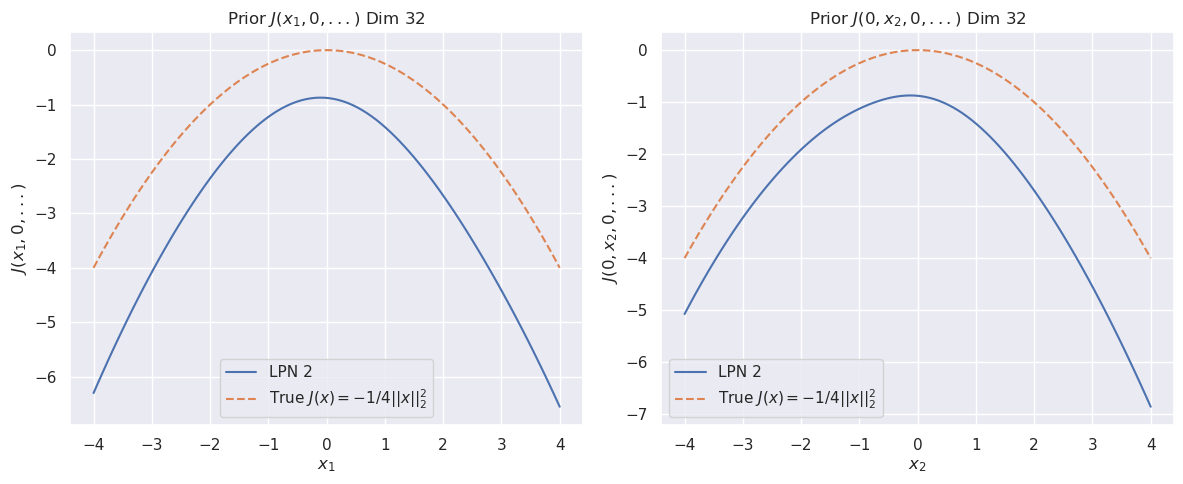

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)